# Survey Validation Data Challenge - Summer 2018

### Notebook 2 -- Tile the BGS/GAMA Fields

The purpose of this notebook is to construct a set of DESI tiles (pointings) for each of the GAMA/BGS fields. 

In [3]:
import os, time
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [4]:
from astropy.table import Table, hstack, Column
import fitsio

In [5]:
%matplotlib inline

In [6]:
print("Starting at {}".format(time.asctime()))
notebook_start_time = time.time()

Starting at Mon Jun 18 18:30:53 2018


### Define the top-level base (output) directory

We assume that *basedir* already has the appropriate GAMA catalogs downloaded.

In [7]:
basedir = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'svdc-summer2018')
samplefile = os.path.join(basedir, 'bgs-gama-sample.fits')

#### Specify whether the output catalog should be overwritten.

If *overwrite_tiles=True* all the output files and plots will be recreated.

In [8]:
overwrite_tiles = True

### Read the parent sample of GAMA targets.
This parent sample was written by the *bgs-gama-sample.ipynb* notebook.

In [11]:
def read_sample():
    if os.path.isfile(samplefile):
        gama = Table(fitsio.read(samplefile, ext=1))
        print('Read {} objects from {}'.format(len(gama), samplefile))
    else:
        print('Sample file {} not found!'.format(samplefile))
        gama = []
    return gama

In [13]:
gama = read_sample()
gama

Read 124683 objects from /Users/ioannis/work/desi/datachallenge/svdc-summer2018/bgs-gama-sample.fits


CATAID,GAMA_NAME,IC_FLAG,N_SPEC,N_GAMA_SPEC,DIST,SPECID,SURVEY,SURVEY_CODE,RA_GAMA,DEC_GAMA,WMIN,WMAX,Z,NQ,PROB,FILENAME,URL,URL_IMG,OBJID_1,TYPE_1,PSFMAG_R,FIBERMAG_R,PETRORAD_R,MODELMAG_U,MODELMAG_G,MODELMAG_R,MODELMAG_I,MODELMAG_Z,D4000N,HB_EW,HA_EW,MABS_U,MABS_G,MABS_R,MABS_I,MABS_Z,FIELD,RELEASE,BRICKID,BRICKNAME,OBJID_2,TYPE_2,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_Y,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_U,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_I,FLUX_IVAR_Z,FLUX_IVAR_Y,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_U,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_I,MW_TRANSMISSION_Z,MW_TRANSMISSION_Y,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_U,NOBS_G,NOBS_R,NOBS_I,NOBS_Z,NOBS_Y,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_U,RCHISQ_G,RCHISQ_R,RCHISQ_I,RCHISQ_Z,RCHISQ_Y,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_U,FRACFLUX_G,FRACFLUX_R,FRACFLUX_I,FRACFLUX_Z,FRACFLUX_Y,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_U,FRACMASKED_G,FRACMASKED_R,FRACMASKED_I,FRACMASKED_Z,FRACMASKED_Y,FRACIN_U,FRACIN_G,FRACIN_R,FRACIN_I,FRACIN_Z,FRACIN_Y,ANYMASK_U,ANYMASK_G,ANYMASK_R,ANYMASK_I,ANYMASK_Z,ANYMASK_Y,ALLMASK_U,ALLMASK_G,ALLMASK_R,ALLMASK_I,ALLMASK_Z,ALLMASK_Y,WISEMASK_W1,WISEMASK_W2,PSFSIZE_U,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFSIZE_Y,PSFDEPTH_U,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_I,PSFDEPTH_Z,PSFDEPTH_Y,GALDEPTH_U,GALDEPTH_G,GALDEPTH_R,GALDEPTH_I,GALDEPTH_Z,GALDEPTH_Y,WISE_COADD_ID,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR
int32,bytes23,int16,int16,int16,float32,bytes33,bytes9,int16,float64,float64,float32,float64,float32,int16,float32,bytes67,bytes88,bytes92,int64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes7,int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
6802,GAMAJ113601.43+004315.3,4104,1,1,0.07,G12_Y3_017_187,GAMA,5,174.006,0.72093,3727.71,8857.67,0.05054,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_017_187.png,588848900983816313,3,19.429546,19.371262,2.344264,20.27464,19.187576,18.69594,18.406414,18.221746,1.8113052,5.2033396,27.802761,-16.343458,-17.391253,-17.939962,-18.259773,-18.439596,G12,5000,335384,1741p007,1933,EXP,174.00598622398962,0.7209393932303215,6988468600000.0,4191433300000.0,419401.47 .. 536835.56,0.022343148,0.0,21.893206,36.97496,0.0,53.05904,0.0,34.971066,24.96587,34.99477,13.33904,0.0,312.8943,194.10887,0.0,48.34676,0.0,1.4591584,0.2886607,0.0008888335,2.0130388e-05,0.9210764,0.9359996,0.95642483,0.9677694,0.97538704,0.9783421,0.99622065,0.9976773,0.99950415,0.9998127,0,7,7,0,6,0,71,71,14,14,0.0,1.2658782,1.3420198,0.0,1.4313744,0.0,1.3802189,0.9311673,0.51

### Tile the G02, G09, G12, and G15 GAMA fields.

Here we produce an overly simplistic three-tile (three-pointing) solution. This code and the corresponding output files should go into *desimodel.footprint*.

From Eddie:

The tilesra2s, tilesdec2s scheme below is also pretty good for filling in the holes in the DESI focal plane with 3 dithers, so any hexagonal-close-packed scheme with ~1.6 degree spacing and that dither pattern should be pretty good.

I can recommend
```
tilesra2b, tilesdec2b = tiling.simpleradecoffscheme(desitiles['ra'][m0], desitiles['dec'][m0], dx=1.4, ang=330)
tilesra2s, tilesdec2s = tiling.simpleradecoffscheme(desitiles['ra'][m0], desitiles['dec'][m0], dx=0.6, ang=42)
```
as providing a simple set of dithers that fill in almost all of the DESI focal plane holes at 3 dithers, given the DESI PASS 1 tiles as a base, though any ~hexagonal scheme with equal density of points to the DESI tiles PASS 1 polyhedron will work equally well.  These are just uniform offsets in ra and dec.


In [17]:
def simple_radec_off_scheme(ras, decs, dx=0.6, ang=42):
    """Take a single covering, define 4 sets of offsets, start with something 
    minimal: need to cover: central bulls-eyes: 0.2 deg and GFA gaps: up to 0.4 deg.

    E. Schlafly 
    
    """
    ang = np.radians(ang)
    dang = np.pi/2
    dithers = [[0, 0], 
               [dx*np.sin(ang+0*dang), dx*np.cos(ang+0*dang)], 
               [dx*np.sin(ang+1*dang), dx*np.cos(ang+1*dang)],
               [dx*np.sin(ang+2*dang), dx*np.cos(ang+2*dang)]]
    dithers = np.cumsum(np.array(dithers), axis=0)
    dithers = list(dithers) + [[np.mean([d[0] for d in dithers]),
                                np.mean([d[1] for d in dithers])]]
    fac = 1./np.cos(np.radians(decs))
    fac = np.clip(fac, 1, 360*5)  # confusion near celestial pole.
    newras = np.concatenate([ras+d[0]*fac for d in dithers])
    newdecs = np.concatenate([decs+d[1] for d in dithers])
    newdecs = np.clip(newdecs, -np.inf, 90.)
    newras = newras % 360
    newras = np.concatenate([newras, newras])
    newdecs = np.concatenate([newdecs, newdecs])
    return newras, newdecs

In [22]:
for field in sorted(set(gama['FIELD'])):
    infield = field == gama['FIELD']
    ra2b, dec2b = simple_radec_off_scheme(gama['RA'][infield], gama['DEC'][infield])
    print(field, len(ra2b), dec2b)

G02 165050 [-5.99969168 -5.99392233 -5.99383348 ... -4.54575011 -4.97131015
 -4.35757089]
G09 227480 [-0.67482602 -0.69165913 -0.68657923 ... -0.86201929 -0.89937352
 -0.66262145]
G12 280920 [ 0.72093939  0.70597865  0.65892343 ... -2.32805802 -1.47328558
 -0.0092702 ]
G15 573380 [ 0.63132259  0.75495627  0.63503613 ... -1.1597161   0.51215729
 -0.89784711]


In [14]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plt.plot(x,y, '-', color=color, alpha=0.5)

In [15]:
def qa_tiles(cat):
    fig, ax = plt.subplots()
    ax.scatter(cat['RA'], cat['DEC'], s=1, alpha=0.5)
    for tt in tiles:
        plot_tile(tt['RA'], tt['DEC'])
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')

In [16]:
def gama_bgs_footprint(overwrite=False):
    """The tiling solution needs to be done properly and the code 
    needs to be moved elsewhere.
    
    """
    ntile = 3
    tiles = Table()
    tiles.add_column(Column(name='TILEID', dtype=np.int32, length=ntile))
    tiles.add_column(Column(name='RA', dtype='f8', length=ntile))
    tiles.add_column(Column(name='DEC', dtype='f8', length=ntile))
    tiles.add_column(Column(name='PASS', dtype=np.int16, length=ntile))
    tiles.add_column(Column(name='IN_DESI', dtype=np.int16, length=ntile))
    tiles.add_column(Column(name='EBV_MED', dtype='f4', length=ntile))
    tiles.add_column(Column(name='AIRMASS', dtype='f4', length=ntile))
    tiles.add_column(Column(name='STAR_DENSITY', dtype='f4', length=ntile))
    tiles.add_column(Column(name='EXPOSEFAC', dtype='f4', length=ntile))
    tiles.add_column(Column(name='PROGRAM', dtype='S4', length=ntile))
    tiles.add_column(Column(name='OBSCONDITIONS', dtype=np.int32, length=ntile))
    
    tiles['RA'] = [31.5, 34.3, 37.1]
    tiles['DEC'] = [-4.8, -5.2, -5.0]
    tiles['TILEID'] = [100000, 100001, 100002]
    tiles['PASS'] = 1
    tiles['AIRMASS'] = 1.0
    tiles['IN_DESI'] = 1 # assume all "in DESI"
    tiles['EXPOSEFAC'] = 1.0
    tiles['PROGRAM'] = 'DARK'
    tiles['OBSCONDITIONS'] = 1
    
    if overwrite:
        print('Writing {}'.format(tilesfile))
        tiles.write(tilesfile, overwrite=overwrite)
    
    return tiles

In [17]:
tiles = gama_bgs_footprint(overwrite=overwrite_tiles)
tiles

Writing /Users/ioannis/repos/desihub/desimodel/data/footprint/sv-bgs-tiles.fits


TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int64,float64,float64,int16,int16,float32,float32,float32,float32,bytes4,int32
100000,31.5,-4.8,1,1,0.0,1.0,0.0,1.0,DARK,1
100001,34.3,-5.2,1,1,0.0,1.0,0.0,1.0,DARK,1
100002,37.1,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1


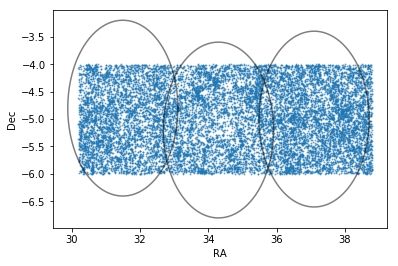

In [18]:
qa_tiles(gama)

### Run survey simulations

Simulate SV observing.

One outstanding question is whether we need a new set of rules when calling *surveyplan* other than those in [desisurvey/data](https://github.com/desihub/desisurvey/tree/master/py/desisurvey/data).

Note that we convert *progress.fits*, which is one row per tile, to *exposures.fits*, which has one row per exposure.

In [19]:
def survey_simulations(overwrite=False):
    """Run survey simulations.
    
    """
    if overwrite or not os.path.isfile(expfile):
        from desisurvey.progress import Progress
        from desisurvey.config import Configuration
        from surveysim.util import add_calibration_exposures
    
        Configuration.reset()
        config = Configuration(surveyconfigfile)

        survey_logname = os.path.join(surveydir, 'survey.log')
        print('Running survey simulations; logging to {}'.format(survey_logname))
        
        with open(survey_logname, 'w') as logfile:
            cmd = "surveyinit --config-file {} --output-path {}".format(surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Use 0d fiber assignment delay to move on with mini sim quickly
            # Do we need new rules?!?
            cmd = "surveyplan --config-file {} --output-path {} --create --fa-delay 0d".format(
                surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            cmd = "surveysim --config-file {} --output-path {} --seed {}".format(
                surveyconfigfile, surveydir, seed)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Do we need new rules?!?
            plan_cmd = 'surveyplan --config-file {} --output-path {} --fa-delay 0d'.format(
                surveyconfigfile, surveydir)
            sim_cmd = 'surveysim --resume --config-file {} --output-path {} --seed {}'.format(
                surveyconfigfile, surveydir, seed)
            while True:
                lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
                progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
                ndone = np.count_nonzero(progress['status'] == 2)
                print('Starting {} with {}/{} tiles completed {}'.format(lastdate, ndone, len(progress), time.asctime()))
                if subprocess.call(plan_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break
                if subprocess.call(sim_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break

        # Make sure observing truly finished.
        progressfile = os.path.join(surveydir, 'progress.fits')
        if not os.path.exists(progressfile):
            print("ERROR: Missing {}".format(progressfile))
            print("Check {} for what might have gone wrong".format(survey_logname))
    
        print('Files in {}:\n'.format(surveydir))
        !ls $surveydir
        
        # convert progress.fits -> exposures.fits
        p = Progress(restore='progress.fits')
        explist = p.get_exposures()
        explist = add_calibration_exposures(explist)

        # Sanity check that all tiles in the subset were observed in the exposures list.
        if not np.all(np.in1d(tiles['TILEID'], explist['TILEID'])):
            print("ERROR: some tiles weren't observed;\ncheck {} for failures".format(survey_logname) )
            print("Missing TILEIDs:", set(tiles['TILEID']) - set(explist['TILEID']))
        else:
            print('All tiles in the subset were observed at least once.')
            explist.write(expfile, overwrite=True)
            print('Writing {}'.format(expfile))                

        # Optionally make a movie
        if False:
            cmd = "surveymovie --config-file {} --output-path {}".format(
                surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0
    else:
        print('Simulated observing has been done.')
        explist = Table.read(expfile)
        print('Read {} exposures from {}'.format(len(explist), expfile))

    return explist

In [20]:
%time explist = survey_simulations(overwrite=overwrite_surveysim)

Running survey simulations; logging to /Users/ioannis/work/desi/survey-validation/survey/survey.log
Starting 2019-09-02 with 0/3 tiles completed Thu Jun  7 09:37:25 2018
Starting 2019-09-03 with 3/3 tiles completed Thu Jun  7 09:37:32 2018
Files in /Users/ioannis/work/desi/survey-validation/survey:

ephem_2019-09-01_2019-11-30.fits stats.fits
exposures.fits                   survey.log
last_date.txt                    surveyinit.fits
plan.fits                        surveymovie.mp4
progress.fits                    weather_1.fits
scheduler.fits
INFO:progress.py:145:__init__: Loaded progress from /Users/ioannis/work/desi/survey-validation/survey/progress.fits.
All tiles in the subset were observed at least once.
Writing /Users/ioannis/work/desi/survey-validation/survey/exposures.fits
CPU times: user 458 ms, sys: 121 ms, total: 579 ms
Wall time: 15.5 s


In [21]:
explist

EXPID,TILEID,PASS,RA,DEC,EBMV,NIGHT,MJD,EXPTIME,SEEING,TRANSPARENCY,AIRMASS,MOONFRAC,MOONALT,MOONSEP,PROGRAM,FLAVOR
,,,deg,deg,,,,s,arcsec,,,,deg,deg,,
int32,int64,int16,float64,float64,float32,str8,float64,float64,float64,float64,float64,float64,float64,float64,str4,str7
0,-1,-1,0.0,0.0,0.0,20190902,58729.30684,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,arc
1,-1,-1,0.0,0.0,0.0,20190902,58729.30730,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,arc
2,-1,-1,0.0,0.0,0.0,20190902,58729.30777,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,arc
3,-1,-1,0.0,0.0,0.0,20190902,58729.30823,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,flat
4,-1,-1,0.0,0.0,0.0,20190902,58729.30869,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,flat
5,-1,-1,0.0,0.0,0.0,20190902,58729.30916,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,flat
6,100000,1,31.5,-4.8,0.0,20190902,58729.30962,1339.0,0.9,1.0,2.0,0.208,-37.0,166.1,DARK,science
7,100000,1,31.5,-4.8,0.0,20190902,58729.32651,1081.5,0.9,1.0,2.0,0.208,-37.0,166.1,DARK,science


### Visualize which healpixels cover the observed tiles.

In [22]:
def tiles2pixels(nside=64):
    import desimodel.footprint
    pixels = desimodel.footprint.tiles2pix(nside, tiles)
    nexp = np.count_nonzero(np.in1d(explist['TILEID'], tiles['TILEID']))
    print('{} tiles covered by {} exposures and {} nside={} healpixels'.format(
        len(tiles), nexp, len(pixels), nside))
    return pixels

In [23]:
def plot_healpix(nside, pixels, ax=None):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    if ax is None:
        fig, ax = plt.subplots()
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        ax.plot(ra, dec, '-', color='0.6') 

In [24]:
def qa_observed_tiles():
    isbright = explist['PROGRAM'] == 'BRIGHT'
    isgray = explist['PROGRAM'] == 'GRAY'
    isdark = explist['PROGRAM'] == 'DARK'
    
    fig, ax = plt.subplots()
    ax.plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.2, label='_none_')
    ax.plot(explist['RA'][isdark], explist['DEC'][isdark], 'o', color='k', ms=10, mew=2, label='dark')
    if np.sum(isgray) > 0:
        ax.plot(explist['RA'][isgray], explist['DEC'][isgray], 's', 
                color='0.6', ms=10, label='gray')
    if np.sum(isbright) > 0:
        ax.plot(explist['RA'][isbright], explist['DEC'][isbright], 'd', 
                color='m', ms=10, mew=2, label='bright')
    ax.legend(loc='upper right')
    #ax.set_xlim(148, 157)
    #ax.set_ylim(28, 37)

In [25]:
def qa_tiles2pixels(nside=64):
    
    pixels = tiles2pixels(nside=nside)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    ax1.plot(tiles['RA'], tiles['DEC'], 'rx')
    ax1.plot(explist['RA'], explist['DEC'], 'b.', alpha=0.5)
    #xlim(0,360); ylim(-20, 80)

    plot_healpix(nside, pixels, ax=ax2)
    color = dict(DARK='k', GRAY='b', BRIGHT='m')
    for program in ['DARK', 'GRAY', 'BRIGHT']:
        ii = tiles['PROGRAM'] == program
        ax2.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
        jj = tiles['PROGRAM'] == program
        for t in tiles[jj]:
            plot_tile(t['RA'], t['DEC'], color=color[program])
    #xlim(143, 161); ylim(28, 37)
    
    return pixels

3 tiles covered by 6 exposures and 48 nside=64 healpixels


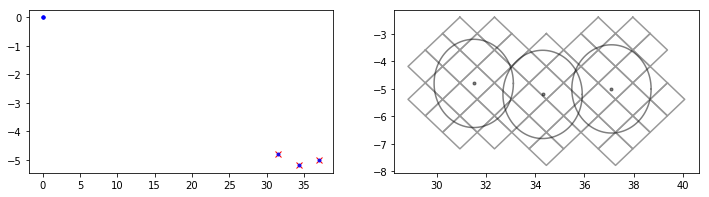

In [26]:
pixels = qa_tiles2pixels()

In [27]:
pixels

array([17670, 17671, 17675, 17676, 17677, 17678, 17679, 17680, 17681,
       17682, 17683, 17684, 17685, 17686, 17687, 17688, 17689, 17690,
       17691, 17692, 17693, 17694, 17695, 17696, 17697, 17698, 17699,
       17700, 17701, 17702, 17703, 17704, 17705, 17707, 17708, 17709,
       17710, 17711, 17712, 17713, 17714, 17720, 17730, 17736, 36794,
       36795, 36798, 36799])